# Covid 19 Analysis

In [143]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [144]:
def split_train_test(inputs, outputs):
    return train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

def train_model(params, search, in_train, out_train):
    start = time.time()
    search.fit(in_train, out_train)
    end = time.time()
    elapsed_time = end - start
    print('Elapsed time: {}mins'.format(elapsed_time / 60))
    print('Best score: {}'.format(search.best_score_))
    print('Best parameters: {}'.format(search.best_params_))
    return search.best_estimator_

    #rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                          #max_depth=100, max_features=3, max_leaf_nodes=None,
                          #max_samples=None, min_impurity_decrease=0.0,
                          #min_impurity_split=None, min_samples_leaf=3,
                          #min_samples_split=8, min_weight_fraction_leaf=0.0,
                          #n_estimators=100, n_jobs=None, oob_score=False,
                          #random_state=None, verbose=0, warm_start=False)
    #rf_estimator.fit(in_conf_train, out_conf_train)
    #return rf_estimator
    
def check_results_test(estimator, in_test, out_test, label):
    estimator_pred = estimator.predict(in_test)
    plt.plot(out_test)
    plt.plot(estimator_pred)
    plt.legend(['Input Data', label])
    print('MAE:', mean_absolute_error(out_test, estimator_pred))
    print('MSE:',mean_squared_error(out_test, estimator_pred))
    print('RMSE:', math.sqrt(mean_squared_error(out_test, estimator_pred)))
    print('R^2:', r2_score(out_test, estimator_pred))
    
def plot_cross_val_score(estimator, inputs, outputs, number_cv):
    cv_scores = cross_val_score(estimator, inputs, outputs, cv=number_cv)
    plt.hist(cv_scores)
    plt.title('Average score: {}'.format(np.mean(cv_scores)))
    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list
    
def plot_predictions_for_country(df, country, estimator, inputs_list, output, label_out, label_pred, title, cumulative=False):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs) 

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    if cumulative:
        country_pred_output = calc_cumulative(country_pred_output)
    
    print('MAE:', mean_absolute_error(country_outputs, country_pred_output))
    print('MSE:',mean_squared_error(country_outputs, country_pred_output))
    print('RMSE:', math.sqrt(mean_squared_error(country_outputs, country_pred_output)))
    print('R^2:', r2_score(country_outputs, country_pred_output))

    plt.plot(days_list, country_outputs, color='blue', label=label_out)
    plt.plot(days_list, country_pred_output, color='green', label=label_pred)
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(title + "(as of {})".format(last_day))
    plt.legend()
    
def plot_learning_curve(estimator, inputs, outputs):
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True,
                                       random_state=None, error_score=np.nan, return_times=False)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Test score')

    plt.ylabel('Score', fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize=18, y=1.03)
    plt.legend()
    
def plot_pred_diff(df, estimator, country, inputs_list, output):
    country_df = df.loc[df["Country/Region"] == country]
    country_inputs = country_df[inputs_list].values
    country_outputs = country_df[output].values
    days_list = df["Num_days_from_begin"].unique()
    country_pred_output = estimator.predict(country_inputs)

    first_day = df["Date"].min()
    last_day = df["Date"].max()

    diff_list = np.subtract(country_outputs, country_pred_output)
    plt.bar(days_list, diff_list, color='blue', label="")
    plt.show()

## 3) Prediction and Regression
### 3.4) K-Nearest Neighbour
- - -

In [145]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


### 3.4.1) Regression for confirmed cases

### Using normalized values as input and using increments as output

In [146]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [147]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [148]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [149]:
# create K-Nearest Neighbours instance, and check the hyper parameters)
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [150]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Elapsed time: 0.08725277582804362mins
Best score: -224409.39048359534
Best parameters: {'p': 1, 'n_neighbors': 13, 'leaf_size': 12}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


KNeighborsRegressor(algorithm='auto', leaf_size=12, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=1,
                    weights='uniform')

MAE: 67.22488144039869
MSE: 135159.3638914136
RMSE: 367.640264241301
R^2: 0.931907265887021


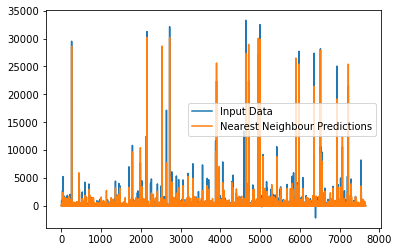

In [151]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

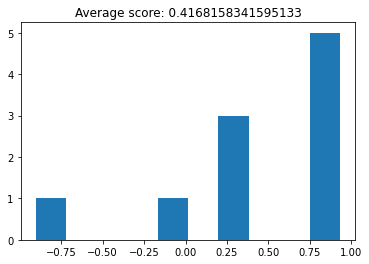

In [152]:
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=14, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=1,
                    weights='uniform')

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

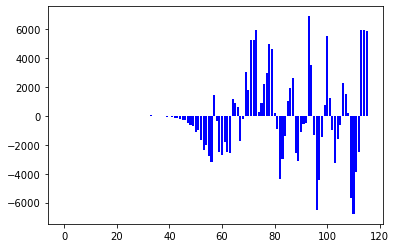

In [153]:
plot_pred_diff(
    df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed_inc"
)

MAE: 5659.430371352794
MSE: 97874948.1088046
RMSE: 9893.176846130094
R^2: 0.9995781568605413


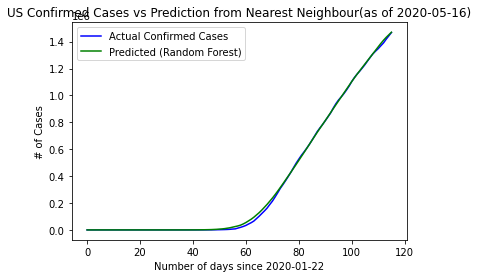

In [154]:
plot_predictions_for_country(
    df, "US", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 32018.450265251984
MSE: 2403301239.172464
RMSE: 49023.47640847662
R^2: 0.7224679816729096


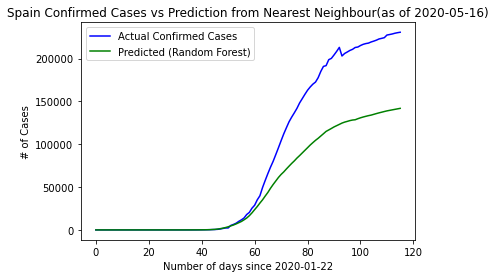

In [155]:
plot_predictions_for_country(
    df, "Spain", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1168.4071618037146
MSE: 9508090.518669644
RMSE: 3083.519177606918
R^2: 0.9968154093379558


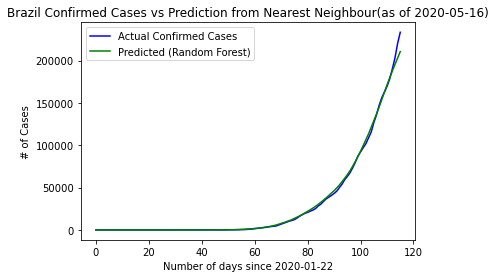

In [156]:
plot_predictions_for_country(
    df, "Brazil", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 22144.11273209549
MSE: 1076915359.0853906
RMSE: 32816.38857469527
R^2: -8.381285615040635


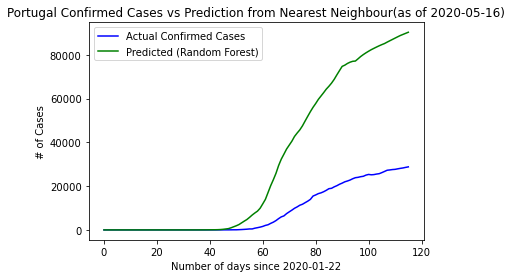

In [157]:
plot_predictions_for_country(
    df, "Portugal", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1775.1014588859398
MSE: 16710074.417312723
RMSE: 4087.7957895805807
R^2: 0.9965204650411419


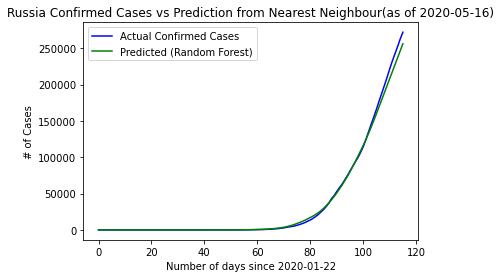

In [158]:
plot_predictions_for_country(
    df, "Russia", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 46666.23541114058
MSE: 4575143348.162874
RMSE: 67639.80594415448
R^2: 0.39351706140701415


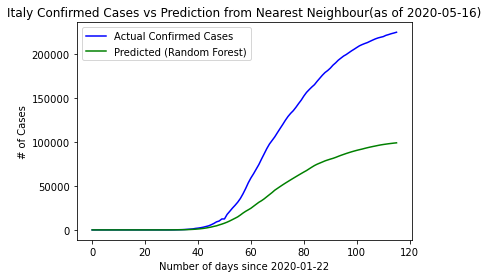

In [159]:
plot_predictions_for_country(
    df, "Italy", knn_estimator, 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

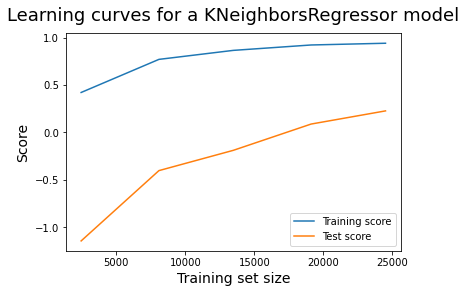

In [160]:
# learning curve
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=14, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=1,
                    weights='uniform')

plot_learning_curve(knn_estimator_2, inputs, outputs)

### Using non normalized values and increment in confirmed values as output

In [161]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [162]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [163]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [164]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Elapsed time: 0.08198659817377726mins
Best score: -168929.86488456282
Best parameters: {'p': 1, 'n_neighbors': 13, 'leaf_size': 28}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


KNeighborsRegressor(algorithm='auto', leaf_size=28, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=1,
                    weights='uniform')

MAE: 60.70743911261153
MSE: 162551.93065886368
RMSE: 403.1772943245486
R^2: 0.8977647263894265


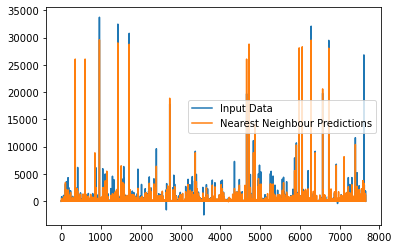

In [165]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

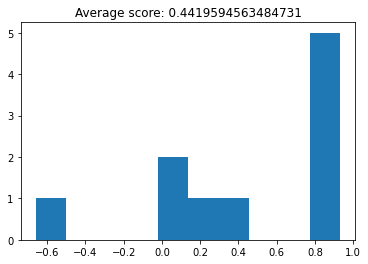

In [166]:
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=1,
                    weights='uniform')

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

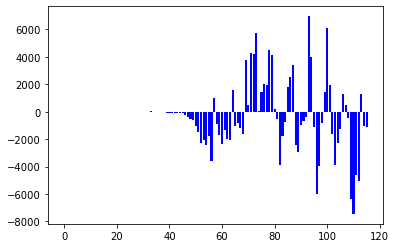

In [167]:
plot_pred_diff(
    df, knn_estimator,
    "US", 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed_inc"
)

MAE: 6306.608753315719
MSE: 119279833.69547288
RMSE: 10921.530739574599
R^2: 0.9994859013415336


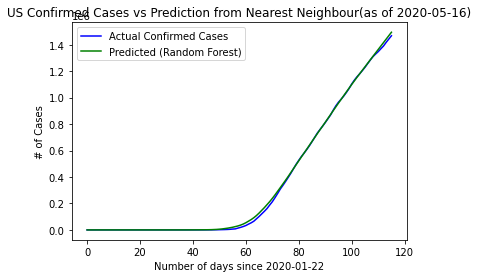

In [168]:
plot_predictions_for_country(
    df, "US", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 23493.001989389923
MSE: 1345801637.2703016
RMSE: 36685.16917325449
R^2: 0.8445875038169833


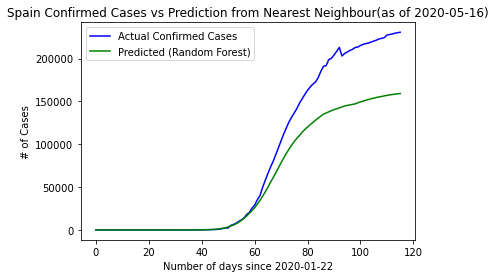

In [169]:
plot_predictions_for_country(
    df, "Spain", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1485.9210875331598
MSE: 10664625.60125492
RMSE: 3265.673835712152
R^2: 0.996428045459047


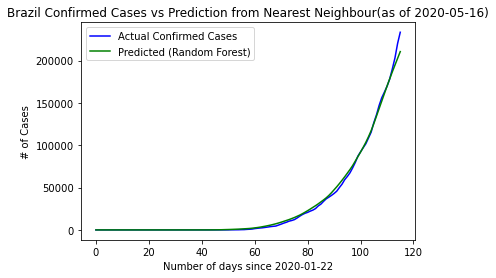

In [170]:
plot_predictions_for_country(
    df, "Brazil", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 13214.468832891249
MSE: 382838706.0293311
RMSE: 19566.26448838232
R^2: -2.3350060573042266


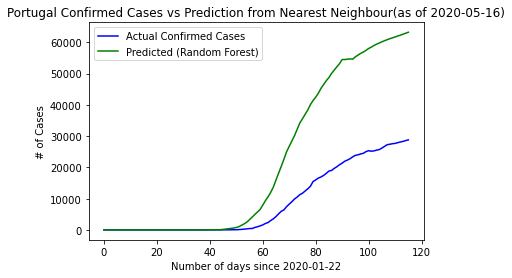

In [171]:
plot_predictions_for_country(
    df, "Portugal", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1162.2340848806398
MSE: 4805218.428330977
RMSE: 2192.0808443875826
R^2: 0.9989994104700692


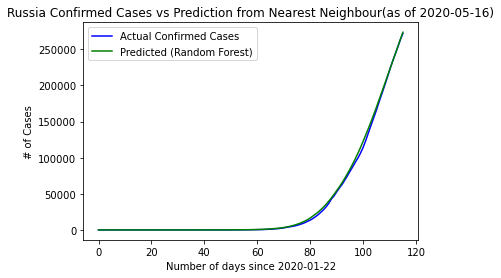

In [172]:
plot_predictions_for_country(
    df, "Russia", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 43762.4177718833
MSE: 4048673489.1506844
RMSE: 63629.1873997357
R^2: 0.4633061287381086


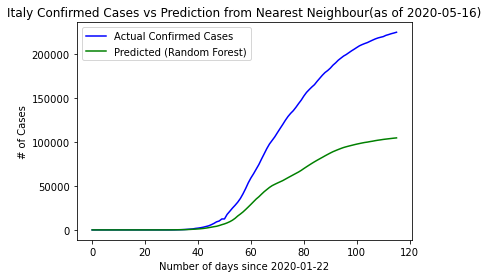

In [173]:
plot_predictions_for_country(
    df, "Italy", knn_estimator, 
    ["Lat", "Long", "Num_days_from_begin"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

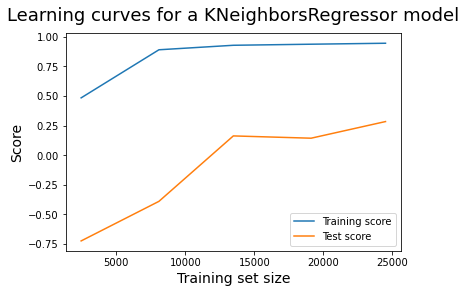

In [174]:
# learning curve
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=16, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=11, p=1,
                    weights='uniform')

plot_learning_curve(knn_estimator_2, inputs, outputs)

### Using increases in confirmed cases and normalized values, using cumulative as output

In [175]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [176]:
outputs = new_df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [177]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [178]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.7s finished


Elapsed time: 0.2010172923405965mins
Best score: -134351.67456346072
Best parameters: {'p': 2, 'n_neighbors': 10, 'leaf_size': 48}


KNeighborsRegressor(algorithm='auto', leaf_size=48, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

MAE: 37.23160737812912
MSE: 78738.23119235836
RMSE: 280.60333425025146
R^2: 0.9400038004462721


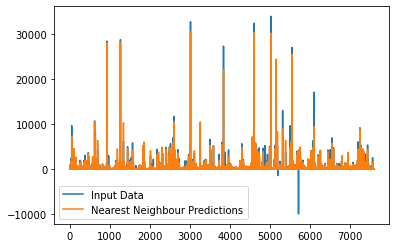

In [179]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

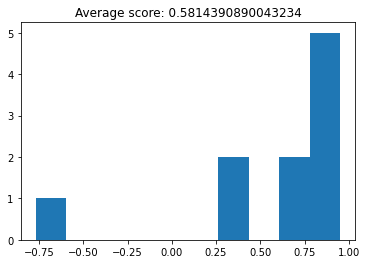

In [180]:
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=15, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                    weights='uniform')

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

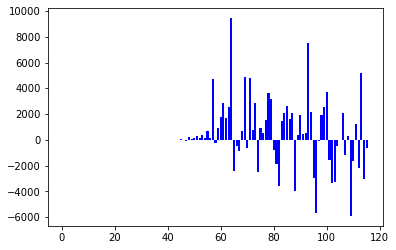

In [181]:
plot_pred_diff(
    new_df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed_inc"
)

MAE: 19252.03826086957
MSE: 801261752.4779135
RMSE: 28306.567302976062
R^2: 0.9965600284608335


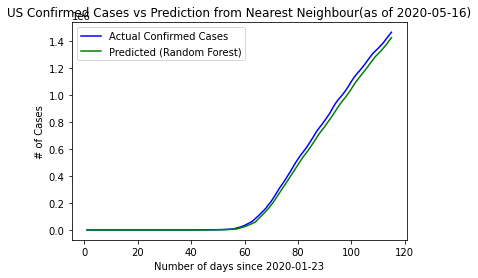

In [182]:
plot_predictions_for_country(
    new_df, "US", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "US Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 7280.843478260833
MSE: 117103350.55530341
RMSE: 10821.430152955912
R^2: 0.9865016087534701


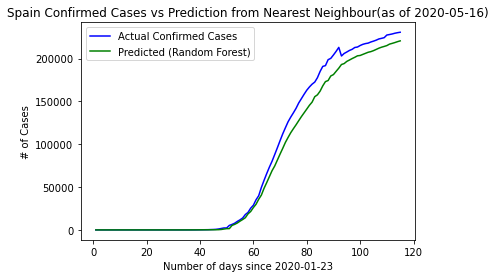

In [183]:
plot_predictions_for_country(
    new_df, "Spain", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Spain Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 3851.2539130434743
MSE: 53526491.07756507
RMSE: 7316.180087830334
R^2: 0.9821787680828239


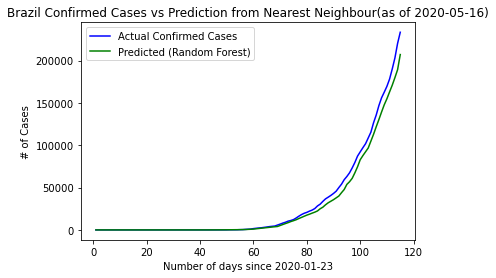

In [184]:
plot_predictions_for_country(
    new_df, "Brazil", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Brazil Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 729.9921739130443
MSE: 1434721.5244347856
RMSE: 1197.798615976319
R^2: 0.9875377238415334


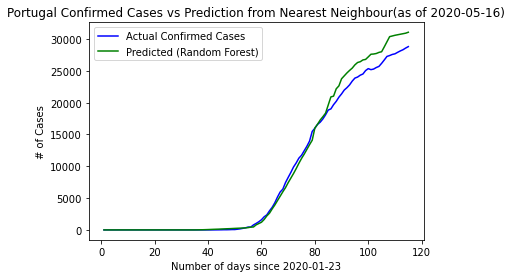

In [185]:
plot_predictions_for_country(
    new_df, "Portugal", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Portugal Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 3071.749565217401
MSE: 19743622.010956578
RMSE: 4443.379570884821
R^2: 0.9973846409986432


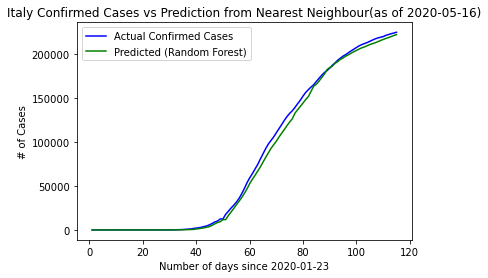

In [186]:
plot_predictions_for_country(
    new_df, "Italy", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Italy Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 1642.1417391304335
MSE: 9771144.412956478
RMSE: 3125.882981328072
R^2: 0.9979780103980741


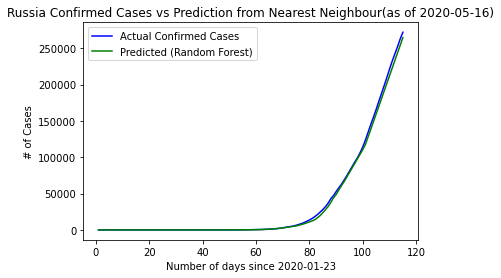

In [187]:
plot_predictions_for_country(
    new_df, "Russia", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], 
    "Confirmed",
    "Actual Confirmed Cases", 
    "Predicted (Random Forest)", 
    "Russia Confirmed Cases vs Prediction from Nearest Neighbour",
    True
)

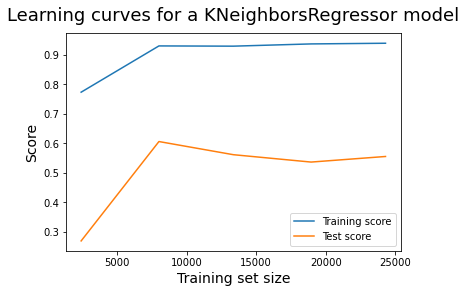

In [188]:
# learning curve
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=15, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                    weights='uniform')

plot_learning_curve(knn_estimator_2, inputs, outputs)

### 3.4.2) Regression for Death Cases
### Using the best combination of parameters found for the confirmed deaths, for K nearest neighbours the best option tested was using increases in confirmed cases and normalized values, using cumulative as output

In [189]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Deaths_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11017732],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11017732],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11017732],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11017732],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11017732],
       [-1.65599721,  0.09994051,  1.71718314, -0.11017732]])

In [190]:
outputs = new_df["Deaths_inc"].values
outputs

array([0., 0., 0., ..., 0., 0., 0.])

In [191]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [192]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.6s finished


Elapsed time: 0.14945297638575236mins
Best score: -817.7211447010872
Best parameters: {'p': 1, 'n_neighbors': 16, 'leaf_size': 10}


KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=16, p=1,
                    weights='uniform')

MAE: 3.378614953886693
MSE: 797.9449609889657
RMSE: 28.247919586917646
R^2: 0.9058714355232944


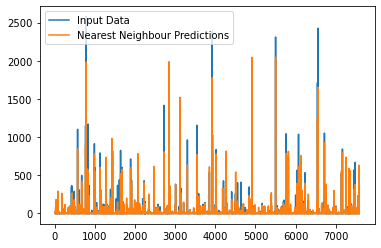

In [193]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

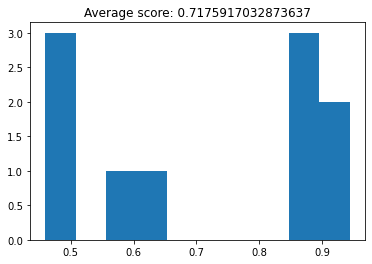

In [194]:
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                    weights='uniform')

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

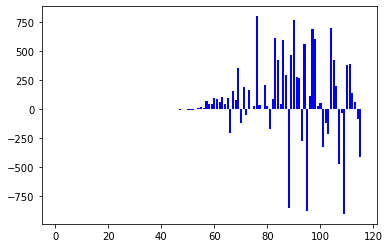

In [195]:
plot_pred_diff(
    new_df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths_inc"
)

MAE: 1758.4722826086957
MSE: 8645369.068851903
RMSE: 2940.3008466570054
R^2: 0.9894749872008418


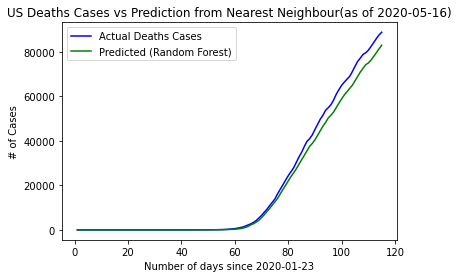

In [196]:
plot_predictions_for_country(
    new_df, "US", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (Random Forest)", 
    "US Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 403.12554347826085
MSE: 321810.3461616848
RMSE: 567.2833032636205
R^2: 0.9971202379696145


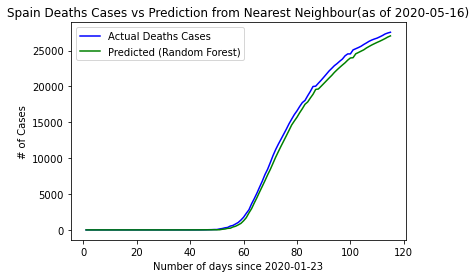

In [197]:
plot_predictions_for_country(
    new_df, "Spain", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (Random Forest)", 
    "Spain Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 188.75108695652173
MSE: 226611.22398097825
RMSE: 476.03699854210726
R^2: 0.9840349267922925


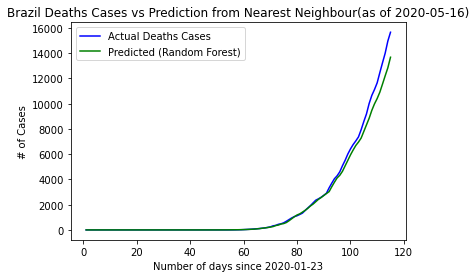

In [198]:
plot_predictions_for_country(
    new_df, "Brazil", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (Random Forest)", 
    "Brazil Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 84.45054347826087
MSE: 26714.785903532607
RMSE: 163.4465842516527
R^2: 0.8538548942509872


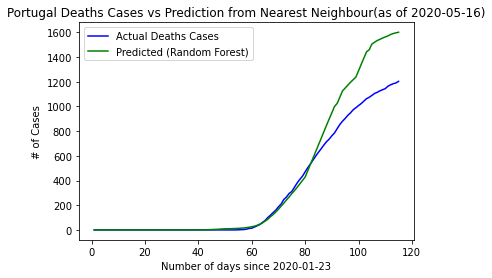

In [199]:
plot_predictions_for_country(
    new_df, "Portugal", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (Random Forest)", 
    "Portugal Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 456.7608695652174
MSE: 353190.7597146739
RMSE: 594.2985442643065
R^2: 0.9975330559629733


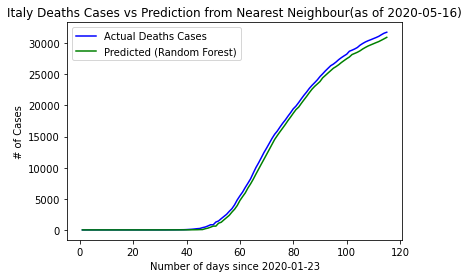

In [200]:
plot_predictions_for_country(
    new_df, "Italy", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (Random Forest)", 
    "Italy Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 9.039673913043478
MSE: 467.11137907608696
RMSE: 21.61275963582825
R^2: 0.9988715940472491


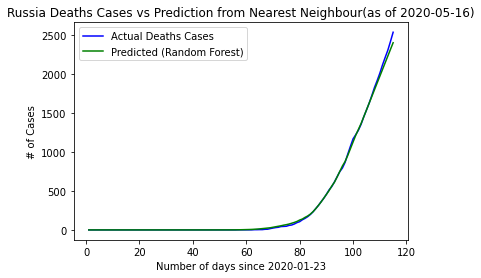

In [201]:
plot_predictions_for_country(
    new_df, "Russia", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Deaths_inc_day_before_norm"], 
    "Deaths",
    "Actual Deaths Cases", 
    "Predicted (Random Forest)", 
    "Russia Deaths Cases vs Prediction from Nearest Neighbour",
    True
)

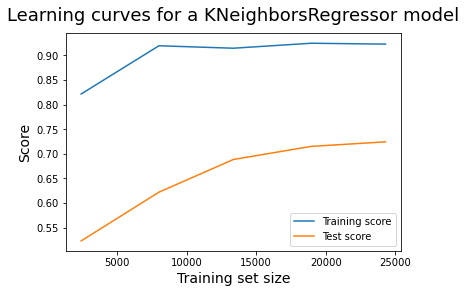

In [202]:
# learning curve
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=1,
                    weights='uniform')

plot_learning_curve(knn_estimator_2, inputs, outputs)

### 3.4.3) Regression for Recovered Cases
### Using the best combination of parameters found for the confirmed deaths, for K nearest neighbours the best option tested was using increases in confirmed cases and normalized values, using cumulative as output

In [203]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Recovered_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.12137308],
       [ 0.79830423, -0.03978737, -1.68731909, -0.12137308],
       [ 0.27177561, -0.30283255, -1.68731909, -0.12137308],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.12137308],
       [ 0.31790115,  1.38034566,  1.71718314, -0.12137308],
       [-1.65599721,  0.09994051,  1.71718314, -0.12137308]])

In [204]:
outputs = new_df["Recovered_inc"].values
outputs

array([ 0.,  0.,  0., ..., 59.,  0.,  0.])

In [205]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = split_train_test(inputs, outputs)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

MAE: 54.99864680821344
MSE: 152723.9953767766
RMSE: 390.799175250891
R^2: 0.19724997958522517


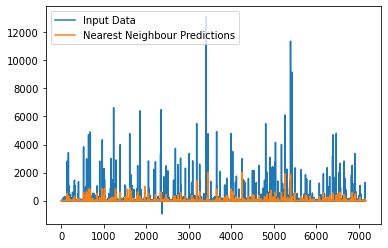

In [206]:
check_results_test(knn_estimator, in_conf_test, out_conf_test, 'Nearest Neighbour Predictions')

In [207]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

search = RandomizedSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
knn_estimator = train_model(param_grid, search, in_conf_train, out_conf_train)
knn_estimator

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


Elapsed time: 0.1469529946645101mins
Best score: -122403.79824187032
Best parameters: {'p': 1, 'n_neighbors': 17, 'leaf_size': 24}


KNeighborsRegressor(algorithm='auto', leaf_size=24, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=17, p=1,
                    weights='uniform')

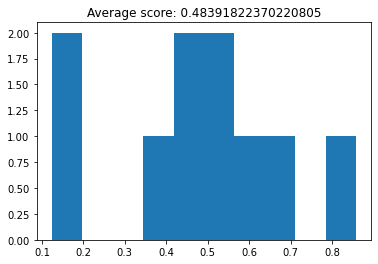

In [208]:
knn_estimator_2 =KNeighborsRegressor(algorithm='auto', leaf_size=11, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                    weights='uniform')

plot_cross_val_score(knn_estimator_2, inputs, outputs, 10)

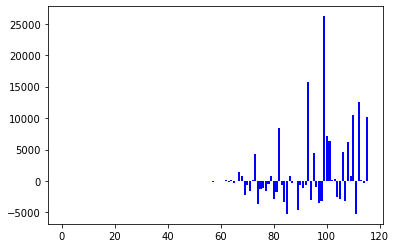

In [209]:
plot_pred_diff(
    new_df, knn_estimator,
    "US", 
    ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered_inc"
)

MAE: 7261.506905370842
MSE: 243287287.74177822
RMSE: 15597.669304796093
R^2: 0.9566468858298423


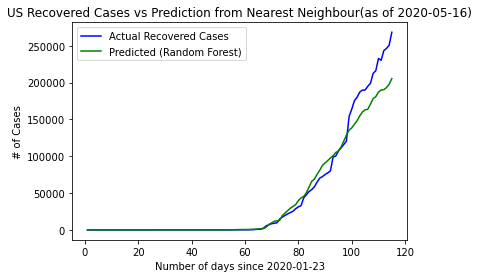

In [210]:
plot_predictions_for_country(
    new_df, "US", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (Random Forest)", 
    "US Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 3798.428644501272
MSE: 33888059.09571221
RMSE: 5821.345127692757
R^2: 0.9861565268883804


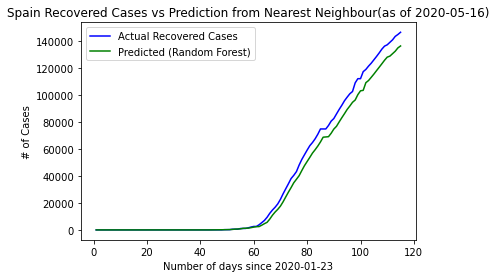

In [211]:
plot_predictions_for_country(
    new_df, "Spain", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (Random Forest)", 
    "Spain Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 854.4971867007674
MSE: 2096912.1488791942
RMSE: 1448.071872829244
R^2: -1.577140890114514


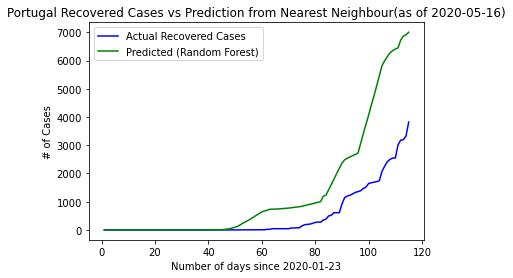

In [212]:
plot_predictions_for_country(
    new_df, "Portugal", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (Random Forest)", 
    "Portugal Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 2979.163171355501
MSE: 20779392.955558944
RMSE: 4558.441943861843
R^2: 0.9837611561779259


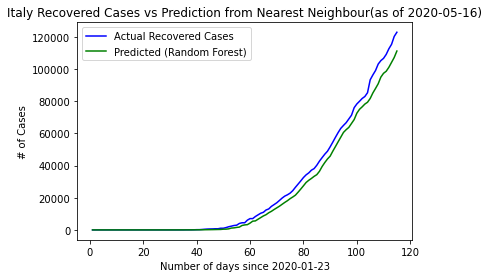

In [213]:
plot_predictions_for_country(
    new_df, "Italy", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (Random Forest)", 
    "Italy Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

MAE: 780.5473145780047
MSE: 4334280.16398375
RMSE: 2081.8934084106586
R^2: 0.9731558132350266


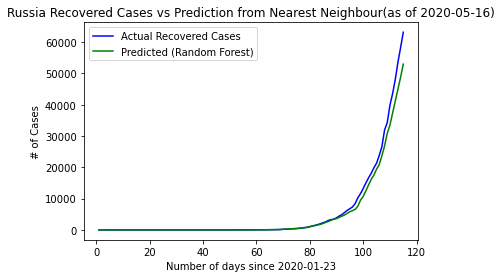

In [214]:
plot_predictions_for_country(
    new_df, "Russia", knn_estimator, 
     ["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Recovered_inc_day_before_norm"], 
    "Recovered",
    "Actual Recovered Cases", 
    "Predicted (Random Forest)", 
    "Russia Recovered Cases vs Prediction from Nearest Neighbour",
    True
)

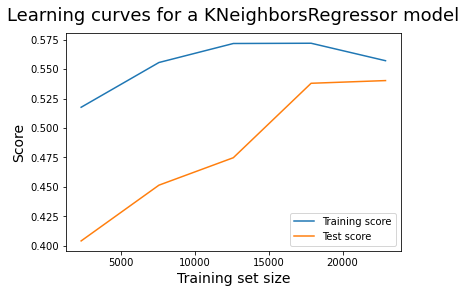

In [215]:
# learning curve
knn_estimator_2 = KNeighborsRegressor(algorithm='auto', leaf_size=11, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                    weights='uniform')

plot_learning_curve(knn_estimator_2, inputs, outputs)